# Chapter 7. 앙상블 학습과 랜덤 포레스트

무작위로 선택된 수천명의 사람에게 복잡한 질문을 하고 대답을 모은다고 가정합시다. 많은 경우 이렇게 모은 답이 전문가의 답보다 낫습니다. 이를 *대중의 지혜*라고 합니다.

이와 비슷하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것입니다. 일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습**(ensemble learning)이라고 하며, 앙상블 학습 알고리즘을 앙상블 방법이라고 합니다. 

예를 들어 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있습니다. 예측을 하려면 모든 개별 트리의 예측을 구하면 됩니다. 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼습니다. 결정 트리의 앙상블을 **랜덤 포레스트**(random forest)라고 합니다. 가장 간단한 방법이지만, 오늘날 가장 강력한 머신러닝 알고리즘 중 하나입니다.


이 장에서는 **배깅, 부스팅, 스태킹** 등 가장 인기있는 앙상블 방법을 설명하겠습니다.



In [2]:
# 시작하기 전에 먼저 필요한 모듈 import!
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 1. 투표 기반 분류기

정확도가 80%인 분류기 여러개를 훈련시켰다고 가정합시다. 아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, k-최근접 이웃 분류기 등을 가지고 있을 수 있습니다.

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것입니다. 이렇게 다수결 투표로 정해지는 분류기를 **직접 투표**(hard voting) 분류기라고 합니다.

조금 놀랍게도, 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많습니다. 사실 각 분류기가 약한 학습기일지라도, 많고 다양하다면 앙상블은 강한 학습기가 될 수 있습니다.

다음은 여러 분류기를 조합하여 사이킷런의 **투표 기반 분류기**(`VotingClassifier`)를 만들고 훈련시키는 코드입니다.


In [4]:
# moons 데이터셋을 읽어와 학습시켜봅시다!
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape)

(375, 2) (125, 2)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma='auto')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier(n_estimators=10)),
                             ('svc', SVC(gamma='auto'))])

각 분류기의 테스트셋 정확도를 확인해봅시다.

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.928
SVC 0.888
VotingClassifier 0.88


VoingClassifier가 꽤 좋은 성적을 보이고 있는 것 같죠? 

모든 분류기가 클래스의 확률을 예측할 수 있으면 (즉, `predict_proba()`메서드가 있으면), 개별 분류기의 예측의 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있습니다. 이를 **간접 투표**(soft voting)이라고 합니다. 이 방식은 확률이 높은 투표에 비중을 두기 때문에 직접 투표 방식보다 성능이 높습니다. 이 방식을 사용하기 위해서는 `voting='hard'`를 `voting='soft'`로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됩니다. `SVC`는 기본값에서는 클래스 확률을 제공하지 않으므로 `probability` 매개변수를 `True`로 지정해야 합니다. (이렇게하면 클래스 확률을 추정하기 위해 교차검증을 사용하므로 훈련 속도가 느려지지만 `SVC`에서 `predict_proba()`를 사용할 수 있습니다.) 앞의 코드를 간접 투표 방식을 사용하도록 변경하면 91%의 정확도를 얻을 것입니다.

## 2. 배깅과 페이스팅

앞서 말했듯이 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것입니다. 또 다른 방법은 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것입니다.

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅**(bagging)(bootstrap aggregating의 줄임말)이라고 하며, 중복을 허용하지않고 샘플링하는 방식을 **페이스팅**(pasting)이라고 합니다.

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있습니다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 할 수 있습니다. 이 샘플링과 훈련 과정은 아래와 같습니다.

![img](https://yganalyst.github.io/assets/images/ML/chap6/bagging1.png)

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만듭니다. 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**(statistical mode)(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산합니다. 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소합니다. 

위 그림에서 볼 수 있듯이 *예측기는 동시에 다른 CPU코어나 서버에서 병렬로 학습시킬 수 있습니다.* 이와 유사하게 예측도 병렬로 수행할 수 있습니다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높습니다.



### 2.1 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 `BaggingClassifier`(회귀의 경우 `BagginRegressor`)를 제공합니다. 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드입니다. 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됩니다. 이 경우는 배깅의 경우이고, 페이스팅을 사용하려면 `bootstrap=False`로 지정하면 됩니다. `n_jobs` 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정합니다.

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

`BaggingClassifier`는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 (즉, `predict_proba()` 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용합니다.


아래 그림은 단일 결정 트리의 결정 경계외 500개의 트리를 사용한 배깅 앙상블의 경계를 비교한 것입니다. 둘다 moons 데이터 셋에 훈련시켰습니다. 여기서 볼 수 있듯이, 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 된 것 같습니다. 앙상블은 비슷한 편향에서 더 작은 분산을 만듭니다.

0.856


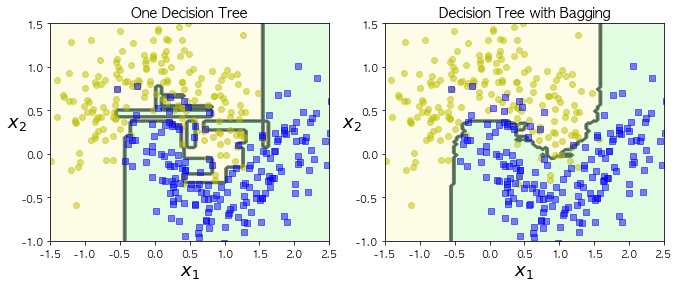

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("One Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.show()

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높습니다. 하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킵니다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호합니다. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋습니다.



### 2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있습니다. `BaggingClassifier`는 기본 값으로 중복을 허용하여(`bootstrap=True`) 훈련 세트 크기만큼 $m$개 샘플을 선택합니다. 이는 평균적으로 각 예측기에 훈련 샘플의 63%만 정도만 샘플링 된다는 것을 의미합니다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 부릅니다. 예측기마다 남겨진 37%는 모두 다릅니다.

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지않고 oob 샘플을 사용해 평가할 수 있습니다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻습니다.

사이킷런에서 `BaggingClassifier`를 만들 때 `oob_score=True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행합니다. 다음 코드는 이 과정을 보여줍니다. 평가 점수 결과는 `oob_score_` 변수에 저장되어 있습니다.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=1, oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

oob 평가 결과를 보면 `BaggingClassifier`는 테스트 세트에서 약 89%의 정확도를 얻을 것으로 보입니다. 확인해봅시다.

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트 세트에서 90%의 정확도를 얻었습니다. 비슷하네요!

oob 샘플에 대한 결정 함수의 값도 `oob_decision_function_` 변수에서 확인할 수 있습니다. 이 경우 결정 함수는 각 훈련의 샘플의 클래스 확률을 반환합니다. (기반이 되는 예측기가 `predict_proba()`를 가지고 있기 때문에) 다음 예를 보면 oob 평가는 첫 번째 훈련 샘플의 양성 클래스에 속할 확률을 59.51%로 추정하고 있습니다.


In [18]:
bag_clf.oob_decision_function_[:5]

array([[0.39226519, 0.60773481],
       [0.34756098, 0.65243902],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 3. 랜덤 패치와 랜덤 서브스페이스

`BaggingClassifier`는 특정 샘플링도 지원합니다. `max_features`, `bootstrap_features` 두 매개변수로 조절됩니다. 작동 방식은 `max_samples`, `bootstrap`과 동일하지만 샘플이 아니고 특성에 대한 샘플링입니다. 따라서 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련 됩니다.

특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용합니다. 훈련 특성과 샘플은 모두 샘플링 하는 것을 **랜덤 패치 방식**(random patches method)라고 합니다. 훈련 샘플을 모두 사용하고, (즉 `bootstrap=False`이고 `max_samples=1.0`) 특성은 샘플링하는(즉, `bootstrap_features=True`이고 `max_features`는 1.0보다 작은) 것을 **랜덤 서브스페이스 방식**(Random subspaces method)이라고 합니다.

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춥니다.

## 4. 랜덤 포레스트

앞서 언급했듯이 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블입니다. 전형적으로 `max_samples`를 훈련 세트의 크기로 지정합니다. `BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 `RandomForestClassifier`를 사용할 수 있습니다. (회귀의 경우 `RandomForestRegressor`) 아래는 최대 16개 리프노드를 가지는 500개의 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드입니다.

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

`RandomForestClassifier`는 몇가지 예외가 있지만 트리의 성장 조절을 위한 `DecisionTreeClassifier` 매개변수와 앙상블 자체를 제어하는 데 필요한 `BaggingClassifier`의 매개변수를 모두 가지고 있습니다.


랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입합니다. 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어 냅니다. 다음은 `BaggingClassifier`를 사용해 앞의 `RandomForestClassifier`와 거의 유사하게 만든 것입니다.

In [22]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 4.1 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용합니다. 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택합니다.

이와같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리**(Extremely Randomized Tree) 앙상블(또는 줄여서 *엑스트라 트리*(Extra Trees))라고 부릅니다. 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 됩니다. 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠릅니다.

엑스트라 트리를 만들려면 사이킷런의 `ExtraTreesClassifier`를 사용합니다. 사용법은 `RandomForestClassifier`와 같습니다. 마찬가지로 회귀 문제의 경우 `ExtraTreesRegressor`를 사용합니다. 

### 4.2 특성 중요도

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것입니다. 사이킷런은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정합니다. 더 정확히 말하자면 가중치 평귱니며 각 노드의 가중치는 연관된 훈련 샘플 수와 같습니다.

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화합니다. 이 값은 `feature_importances_` 변수에 저장되어 있습니다. 예를 들어 다음 코드는 iris 데이터 셋에 `RandomForestClassifier`를 훈련시키고 각 특성의 중요도를 출력합니다. 가장 중요한 특성은 꽃잎의 길이(44%)와 너비(42%이고 꽃받침의 길이와 너비는 비교적 덜 중요해 보입니다.)

In [24]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10219271849647932
sepal width (cm) 0.024830945208919042
petal length (cm) 0.4211534143320126
petal width (cm) 0.45182292196258905


랜덤 포레스트는 특히 특성을 선택해야할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리합니다.

## 5. 부스팅

**부스팅**(boosting)은 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법을 말합니다. 부스팅 방법의 아이디어는 앞의 모델을 보안해나가면서 일련의 예측기를 학습시키는 것입니다. 부스팅 방법은 여러가지가 있지만 가장 있기있는 것은 **아다부스트**(AdaBoost)(Adaptive Boosting의 줄임말)와 **그래디언트 부스팅**(Gradient Boosting)입니다. 

### 5.1 아다부스트

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것입니다. 이렇게 하면 훈련 샘플은 학습하기 어려운 샘플에 점점 더 맞춰지게 됩니다. 이것이 아다부스트에서 사용하는 방식입니다.

예를들어 아다부스트 분류기를 만드려면 기반이 되는 첫 번째 분류기 훈련 세트에서 훈련 시키고 예측을 만듭니다. 그 다음에 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높입니다. 두 번째 분류기는 업데이트 된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듭니다. 그 다음에 다시 가중치를 업데이트 하는 식으로 계속됩니다. 

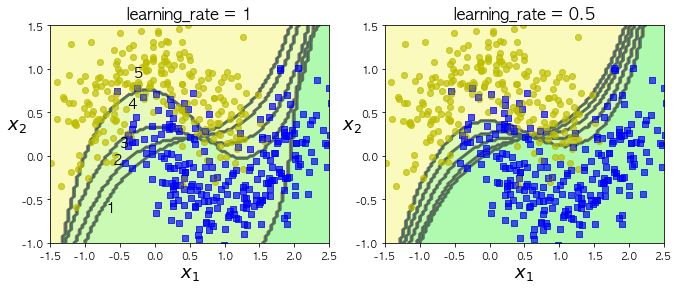

In [26]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

위 그림은 moons 데이터셋에 훈련시킨 다섯개의 연속된 예측기의 결정 경계입니다. 첫 번째 분류기가 많은 샘플에서 잘못 분류해서 이 샘플들의 가중치가 높아져 두번째 분류기에서는 이 샘플들에 대해 좀 더 정확한 예측을 합니다. 오른쪽 그래프는 학습률을 절반으로 낮춘것을 빼면 똑같은 예측기를 나타냅니다. 

그림에서 볼 수 있듯이 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있습니다. 경사 하강법은 비용함수를 최소화하기위해 한 예측기의 모델 파라미터를 조정해가는 반면 아다부스트는 점차 좋아지도록 앙상블에 예측기를 추가합니다.

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듭니다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됩니다.



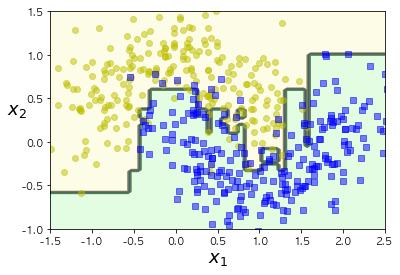

In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

사이킷런은 SAMME라는 아다부스트의 다중 클래스 버전을 사용합니다. 클래스가 두개 뿐일때에는 SAMME가 아다부스트와 동일합니다. 예측기가 클래스의 확률을 추정할 수 있다면, (즉 `predict_proba()` 메서드가 있다면) 사이킷런은 SAMME.R (끝의 R은 'Reat'을 의미합니다.)라는 SAMME의 변종을 사용합니다. 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋습니다.

위 코드는 `AdaBoostClassifier`를 사용하여 200개의 아주 얕은 결정트리를 기반으로 하는 아다부스트 분류기를 훈련시킵니다. 마찬가지로 회귀 문제의 경우 `AdaBoostRegressor`를 사용할 수 있습니다.

### 5.2 그래디언트 부스팅

인기가 높은 또 하나의 부스팅 알고리즘은 **그래디언트 부스팅**(Gradient Boosting)입니다. 아다부스트처럼 그래디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가합니다. 하지만 아다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**(residual error)에 새로운 예측기를 학습시킵니다.

결정 트리 기반 예측기로 사용하는 간단한 회귀 문제를 살펴봅시다. 이를 먼저 `DecisionTreeRegressor`를 훈련 세트에 학습시키고, 이 예측기에서 생긴 잔여 오차에 `DecisionTreeRegressor`를 훈련시킵니다. 

In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [34]:
y2 = y - tree_reg1.predict(X) # 잔여 오차로 학습시킨다!
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [36]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

이제 세개의 트리를 포함하는 앙상블 모델이 생겼습니다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됩니다.

In [38]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([1.08692075])

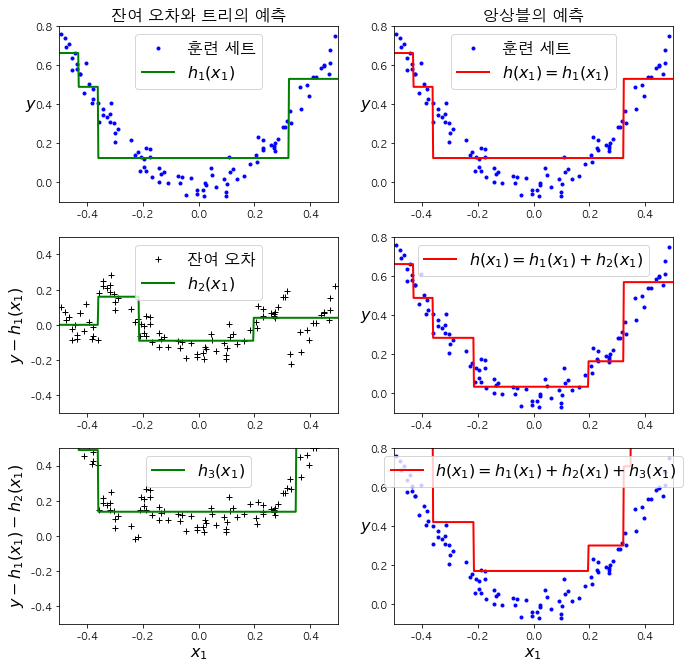

In [42]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

위 그림의 왼쪽열은 이 트리의 예측이고 오른쪽 열은 앙상블의 예측입니다. 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 완전히 똑같습니다. 부전째 행부터는 새로운 트리가 첫번째 트리의 잔여 오차에 대해 학습되었습니다. 오른쪽 앙상블의 예측이 두개 트리의 예측의 합과 같은 것을 확인하 수 있습니다. 세번재 행에서는 두번째 트리의 잔여오차에 훈련되었습니다. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있습니다.

사이킷런의 `GradientBoostRegressor`를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있습니다. 트리 수(`n_estimators`)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론 `RandomForestRegressor`와 아주 비슷하게 결정 트리의 성장을 제어하는 매개 변수 (`max_depth`, `min_samples_leaf` 등)를 가지고 있습니다. 다음은 이전에 만든 것과 같은 앙상블을 만드는 코드입니다.

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=42)

`learning_rate` 매개변수가 각 트리의 기여 정도를 조절합니다. 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아집니다. 이는 **축소**(shrinkage)라고 부르는 규제 방법입니다. 아래 그림은 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블을 보여줍니다.

In [46]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

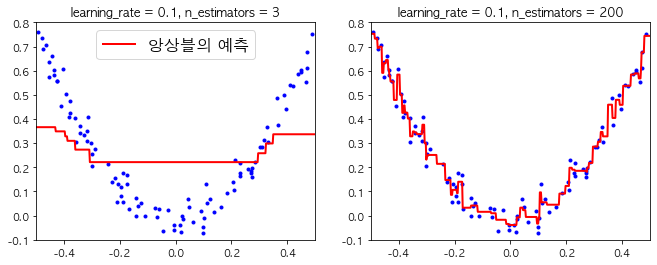

In [48]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='앙상블의 예측')
plt.title("learning_rate = {}, n_estimators = {}".format(gbrt.learning_rate, gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate = {}, n_estimators = {}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators))

plt.show()

왼쪽은 훈련 세트를 학습시키기에 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대 적합되었습니다. 최적의 트리 수를 찾기 위해서는 *조기 종료*를 사용할 수 있습니다. 간단하게 구현하려면 `staged_predict()`메서드를 사용합니다. 이 메서드는 훈련의 각 단계(트리 하나, 트리 두개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환합니다. 다음 코드는 120개읱 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정합니다. 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킵니다.

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=55)

In [52]:
min_error = np.min(errors)

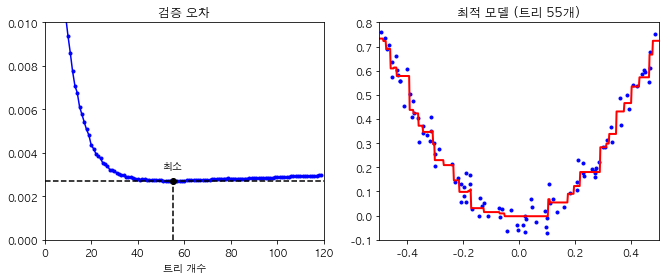

In [54]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha='center')
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차")

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 {}개)".format(bst_n_estimators))

plt.show()

많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 대신 실제로 훈련을 중지하는 방법으로 조기종료를 구현할 수 있습니다. `warm_start=True`로 설정하면 사이킷런이 `fit()`메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줍니다. 다음 코드는 연속해서 다섯 번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈춥니다.

In [56]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimaotrs in range(1, 120):
    gbrt.n_estimaotrs = n_estimaotrs
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
             break # 조기 종료   

In [58]:
print(gbrt.n_estimaotrs)
print("최소 검증 MSE : ", min_val_error)

6
최소 검증 MSE :  0.0028728214372896244


`GradientBoostingRegressor`는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 `subsample` 매개변수도 지원합니다. 예를 들어 `subsample=0.25`라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됩니다. 아마 추측할 수 있겠지만 편향이 높아지는 대신 분산이 낮아지게 됩니다. 또한 훈련 속도를 상당히 높입니다. 이런 기법을 **확률적 그래디언트 부스팅**(stochastic gradient boosting)이라고 합니다.

## 6. 스태킹

이 장에서 이야기할 마지막 앙상블 모델은 **스태킹**(Stacking)(stacked generalization의 줄임말)입니다. 이는 '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델 자체를 훈련시킬 수는 없을까?'라는 기본 아이디어에서 출발합니다. 아래 그림은 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여주고 있습니다. 아래의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(**블렌더**(blender)또는 **메타 학습기**(meta learner)라고 합니다)가 이 예측을 입력으로 받아 최종 예측을 만듭니다. 

![img](https://hwk0702.github.io/img/ensemble10.png)

블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것입니다. 어떻게 작동하는지 살펴봅시다. 먼저 훈련 세트를 두개의 서브셋으로 나눕니다. 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됩니다.

![img](https://hwk0702.github.io/img/ensemble11.png)

그런 다음 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만듭니다. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것입니다. 이제 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 만들어집니다. 타깃 값은 그대로 쓰고 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있습니다. 블렌더가 새 훈련 세트로 훈련됩니다. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됩니다. 

![img](https://hwk0702.github.io/img/ensemble12.png)

사실 이런 방식의 블렌더를 여러 개 훈련 시키는 것도 가능합니다. 그렇게 한다면 블렌더만의 레이어가 만들어지게 됩니다. 이렇게 하려면 훈련 세트를 세 개의 서브셋으로 나눕니다. 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는 두 번째 레이어를 훈련시키기는데 사용되고 두번째 세트는 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됩니다. 그리고 세 번재 세트는 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됩니다. 작업이 끝나면 아래 그림처럼 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있습니다. 

![img](https://hwk0702.github.io/img/ensemble13.png)

---

## 요약 정리하기

1. 앙상블 : 여러 예측기를 훈련시켜 좋은 모델을 만드는 방법.
2. 랜덤 포레스트 : 결정트리의 앙상블
3. 투표 기반 분류기
    - 직접 투표 : 다수결 투표로 정해지는 분류기
        - 사이킷런의 `VotingClassifier`에서 매개변수 `voting='hard'`로 설정을 통해 학습 가능
    - 간접 투표 : 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측하는 방식
        - `VotingClassifier`에서 매개변수 `voting='soft'`로 바꾸면 가능
4. 배깅
    - 훈련 세트의 **중복을 허용**
    - 사이킷런에 `BaggingClassifier` 제공하고 있다. 배깅의 경우 `bootstrap=True`(디폴트 값)으로 지정.
5. 페이스팅
    - 훈련 세트의 **중복ㅇ을 허용하지 않음**
    - 배깅과 마찬가지로 `BaggingClassifier`를 사용하는데 `bootstrap=False`로 설정하면 된다.
6. oob
    - 중복을 허용해 샘플링을 하면 평균적으로 각 예측기에 훈련 샘플의 63%정도만 샘플링된다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 부른다.
    - 사이킷런에서 `BaggingClassifier`를 만들 때 `oob_score=True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다. 평가 점수 결과는 `oob_score_`에 저장되어 있다. 
7. 랜덤 패치
    - 훈련 특성과 샘플을 모두 샘플링 하는 것.
8. 랜덤 서브스페이스
    - 훈련 샘플을 모두 사용하고 특성은 샘플링 하는 것. 
9. 랜덤 포레스트   
    - 배깅 방법을 적용한 결정트리의 앙상블
    - `max_samples`를 통해 훈련 세트의 크기를 지정
    - 사이킷런에서 `RandomForestClassifier` 제공 
10. 엑스트라 트리
    - 랜덤 포레스트에서 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용하는데, 트리를 더욱 무작위로 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 트리의 랜덤 포레스트를 익스트림 랜덤 트리 앙상블, 줄여서 엑스트라 트리라고 부른다.
    - 사이킷런에서 `ExtraTreesClassifier`를 제공한다
11. 특성 중요도
    - 특성의 상대적 중요도.
    - 랜덤포레스트에서는 특성의 사앧적 중요도를 측정할 수 있다. 이 값은 `feature_importances_` 변수에 저장되어 있다.
12. 부스팅
    - 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 방식. 
    1. 아다부스트 
        - 과소적합했던 이전 샘플의 가중치를 높이는 방식
        - 사이킷런에서 `AdaBoostClassifier`를 제공
    2. 그래디언트 부스팅
        - 이전 예측기가 만든 잔여 오차에 대해 새로운 학습기를 학습시키는 방식. 
        - 결정트리에서 그래디언트 부스팅을 사용한 방식을 그래디언트 부스티드 회귀 트리(GBRT)라고 하는데, 사이킷런의 `GradientBoostingRegressor`통해 구현할 수 있다. 
13. 스태킹
    - 앙상블 취합하는 모델을 훈련시키는 방식.
    - 사이킷런에서 직접 지원하지는 않고 있다. 